## Задача 2. А/В - тестирование

Задание:

провести A/B тестирование для представленного датасета.

Pipeline:

1. Визуализация данных

2. t-test

3. Тесты Хи-квадрат

4. Бутстрап анализ

5. Конверсии групп

6. Анализ доверительного интервала

7. Вывод по итогу эксперимента

## Часть 1: Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import t

## Часть 2: Загрузка и обзор данных

In [ ]:
from google.colab import files

In [ ]:
files.upload();

Saving Games_AB.csv to Games_AB.csv


In [ ]:
df = pd.read_csv('Games_AB.csv')

In [ ]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


* sum_gamerounds — количество сыгранных раундов в первые 14 дней (количественные данные).
* retention_1 — пользователь вернулся через 1 день после установки (качественные данные).
* retention_7 — пользователь вернулся через 7 дней после установки (качественные данные).

В качестве конверсии считаем возврат пользователя после установки.

## Часть 3: А/В тестирование

### 3.1. Визуализация данных (первичная)

In [ ]:
# анализировать будем по 3 метрикам:
# 1) количество сыгранных раундов в первые 14 дней,
# 2) количество пользователей, вернувшихся через 1 день после установки,
# 3) количество пользователей, вернувшихся через 7 дней после установки

group_a_gamerounds = df[df['version']=='gate_30']['sum_gamerounds']
group_b_gamerounds = df[df['version']=='gate_40']['sum_gamerounds']
group_a_1 = df[df['version']=='gate_30']['retention_1']
group_b_1 = df[df['version']=='gate_40']['retention_1']
group_a_7 = df[df['version']=='gate_30']['retention_7']
group_b_7 = df[df['version']=='gate_40']['retention_7']

In [ ]:
# визуализация по долям пользователей, вернувшихся после установки через 1 или 7 дней, из контрольной и тестовой групп

df_gate_30_1 = df[df['version']=='gate_30']['retention_1'].value_counts()
df_gate_30_7 = df[df['version']=='gate_30']['retention_7'].value_counts()

In [ ]:
df_gate_40_1 = df[df['version']=='gate_40']['retention_1'].value_counts()
df_gate_40_7 = df[df['version']=='gate_40']['retention_7'].value_counts()

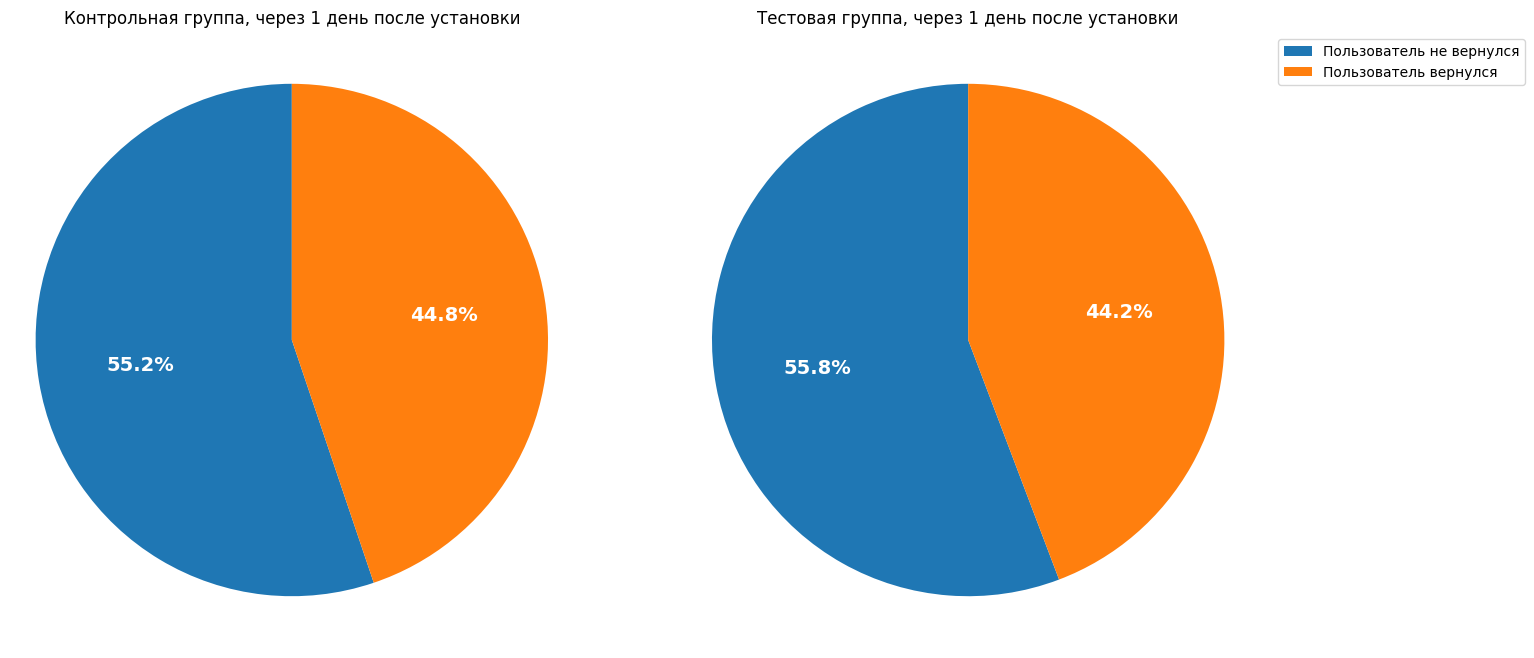

In [ ]:
labels = ['Пользователь не вернулся', 'Пользователь вернулся']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

wedges1, texts1, autotexts1 = axs[0].pie(df_gate_30_1, autopct='%1.1f%%', startangle=90, textprops=dict(color='w'))
#axs[0].legend(wedges1, labels, loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
axs[0].set_title('Контрольная группа, через 1 день после установки', y=1)
plt.setp(autotexts1, size=14, weight='bold')
axs[0].axis('equal')

wedges1, texts1, autotexts1 = axs[1].pie(df_gate_40_1, autopct='%1.1f%%', startangle=90, textprops=dict(color='w'))
axs[1].legend(wedges1, labels, loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
axs[1].set_title('Тестовая группа, через 1 день после установки', y=1)
plt.setp(autotexts1, size=14, weight='bold')
axs[1].axis('equal')

# Выводим изображение
plt.show()

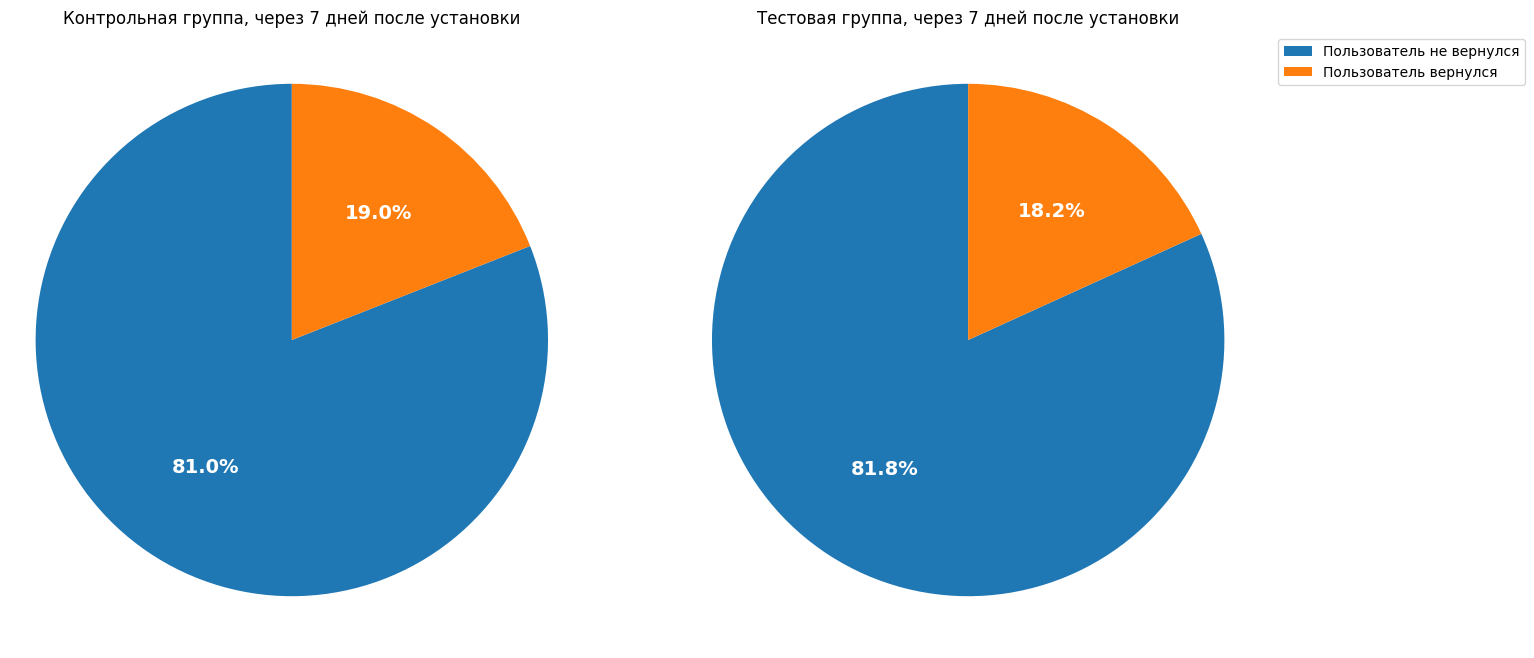

In [ ]:
labels = ['Пользователь не вернулся', 'Пользователь вернулся']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))


wedges2, texts2, autotexts2 = axs[0].pie(df_gate_30_7, autopct='%1.1f%%', startangle=90, textprops=dict(color='w'))
#axs[0].legend(wedges2, labels, loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
axs[0].set_title('Контрольная группа, через 7 дней после установки', y=1)
plt.setp(autotexts2, size=14, weight='bold')
axs[0].axis('equal')

wedges2, texts2, autotexts2 = axs[1].pie(df_gate_40_7, autopct='%1.1f%%', startangle=90, textprops=dict(color='w'))
axs[1].legend(wedges2, labels, loc='best', bbox_to_anchor=(1, 0, 0.5, 1))
axs[1].set_title('Тестовая группа, через 7 дней после установки', y=1)
plt.setp(autotexts2, size=14, weight='bold')
axs[1].axis('equal')

# Выводим изображение
plt.show()

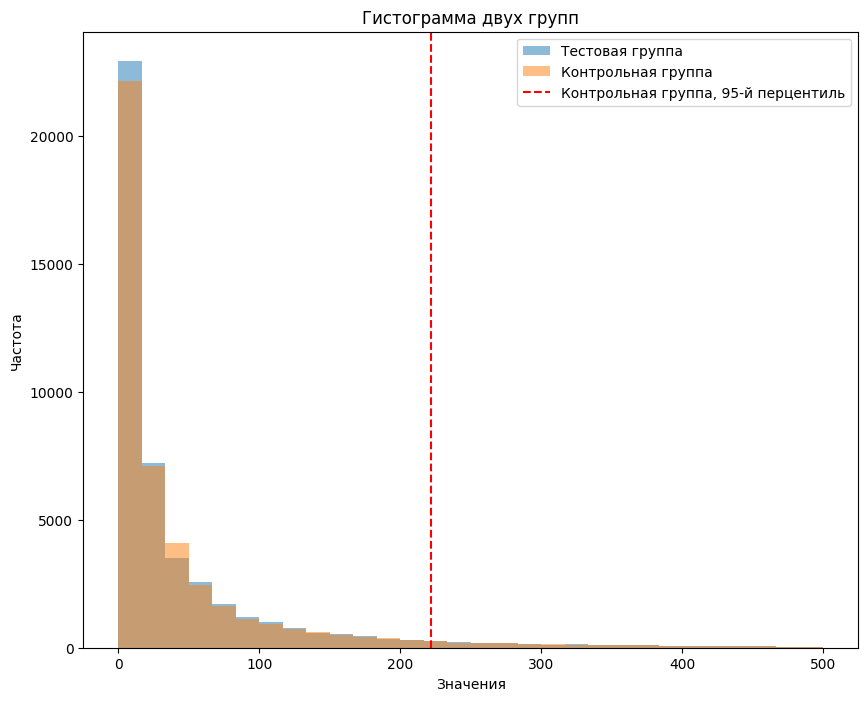

In [ ]:
# визуализация по количеству сыгранных раундов в первые 14 дней

x = np.percentile(group_a_gamerounds, 95)

plt.figure(figsize= (10, 8))
plt.hist(group_b_gamerounds, bins=30, alpha=0.5, label='Тестовая группа', range=(0, 500))
plt.hist(group_a_gamerounds, bins=30, alpha=0.5, label='Контрольная группа', range=(0, 500))
plt.axvline (x=x, color='r', linestyle='dashed', label='Контрольная группа, 95-й перцентиль')
plt.xlabel('Значения')
plt.ylabel ('Частота')
plt.title('Гистограмма двух групп')
plt.legend()
plt.show()

In [ ]:
# дополнительно рассчитаем среднее количество сыгранных раундов в контрольной и тестовой группе

group_a_gamerounds.mean()

52.45626398210291

In [ ]:
group_b_gamerounds.mean()

51.29877552814966

### Вывод по разделу

По графикам pie мы видим, что в тестовой группе количество вернувшихся пользователей чуть меньше, чем в контрольной, при чём это касается возврата как через 1 день после установки, так и через 7 дней.

В отношении количества сыгранных раундов визуально распределение примерно одинаково, однако при дополнительном расчете мы видим, что среднее количество раундов в контрольной группе чуть больше.

Предварительно мы можем сделать вывод, что вариант, предложенный группе B, хуже, поэтому внедрять эти изменения дальше не стоит. Однако необходимо проверить статистическую значимость этих различий, что сделано далее.

### 3.2. Параметрические критерии сравнения групп

T-тест проводим только для количественных данных, т.е. только для данные о количестве сыгранных раундов.

In [ ]:
# t-тест проводится только для данных распределённых нормально, поэтому проверим нормальность распределения при помощи критерия Шапиро-Уилка

shapiro(group_a_gamerounds)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.08805108070373535, pvalue=0.0)

In [ ]:
shapiro(group_b_gamerounds)

ShapiroResult(statistic=0.48256635665893555, pvalue=0.0)

Как видим, p-value меньше 0.05 в обоих случаях, а это означает, что данные выборки не получены из нормального распределения и применять t-критерий Стьюдента будет некорректно.
В данном случае можем применить критерий Манна-Уитни.

In [ ]:
# напишем функцию, указывающую результат теста

def result(p_value, alpha):
    negative = 'Статистически значимых различий между группами не обнаружено.'
    positive = 'Обнаружены статистически значимые различия между группами.'

    if p_value > alpha:
        return negative
    else:
        return positive

In [ ]:
# Порог значимости
alpha = 0.05

# T-тестирование
statistic_mw, p_value_mw = mannwhitneyu(group_a_gamerounds, group_b_gamerounds)
statistic_mw, p_value_mw

print('Результаты в отношении количества сыгранных раундов')
print(f'Значение p-значения: {p_value_mw}')
print(result(p_value_mw,alpha))

Результаты в отношении количества сыгранных раундов
Значение p-значения: 0.05020880772044255
Статистически значимых различий между группами не обнаружено.


### Вывод по разделу (количественные данные)
На основании теста сравнения групп мы делаем вывод, что статистически значимые различия между группами не обнаружены с точки зрения количества сыгранных матчей.
Однако p-value фактически очень близко к порогу значимости, что означает, что можно принять осторожный подход и оставить нулевую гипотезу о наличии статистически значимого различия, осознавая, что результаты не достигают статистической значимости при уровне значимости 0.05.
Возможно, стоит провести более крупное исследование для получения более точных результатов.

Для данных булевого типа (наличие или отсутствие конверсии через 1 или 7 дней) используем тест Хи-квадрат.

In [ ]:
# Выполняем тесты Хи-квадрат

contingency_table_1 = pd.crosstab(df['version'], df['retention_1'])
chi2_1, p_value_1, _, _  = chi2_contingency(contingency_table_1)

contingency_table_7 = pd.crosstab(df['version'], df['retention_7'])
chi2_7, p_value_7, _, _  = chi2_contingency(contingency_table_7)

In [ ]:
# Выводим результаты теста Хи-квадрат
print("\nРезультаты теста Хи-квадрат для возврата через 1 день:")
print(f"Статистика Хи-квадрат = {chi2_1}")
print(f"p-значение = {p_value_1}")

print("\nРезультаты теста Хи-квадрат для возврата через 7 дней:")
print(f"Статистика Хи-квадрат = {chi2_7}")
print(f"p-значение = {p_value_7}")


Результаты теста Хи-квадрат для возврата через 1 день:
Статистика Хи-квадрат = 3.1591007878782262
p-значение = 0.07550476210309086

Результаты теста Хи-квадрат для возврата через 7 дней:
Статистика Хи-квадрат = 9.959086799559167
p-значение = 0.0016005742679058301


### Вывод по разделу (качественные данные)
Для конверсии через 1 день не можем считать результат статистически значимым, так как p-value более 0.05.
Для конверсии через 7 дней результат статистически значим, так как p-value менее 0.05.

Это означает, что результат внедрения изменений по метрике возврата через 7 дней хуже, чем до изменений, а по прочим изменениям различия статистически не значимы.

### 3.3. Бутстрап анализ

In [ ]:
# проведём бутстрап-анализ для оценки различий в средних коэффициентах конверсии между двумя группами

def bootstrap_means(data, n_bootstrap_samples=10000):
    bootstrap_sample_means = []
    for _ in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(df), replace=True)
        bootstrap_sample_means.append(bootstrap_sample.mean())
    return bootstrap_sample_means

bootstrap_means_A_1 = bootstrap_means(df[df['version'] == 'gate_30']['retention_1'])
bootstrap_means_B_1 = bootstrap_means(df[df['version'] == 'gate_40']['retention_1'])
bootstrap_means_A_7 = bootstrap_means(df[df['version'] == 'gate_30']['retention_7'])
bootstrap_means_B_7 = bootstrap_means(df[df['version'] == 'gate_40']['retention_7'])

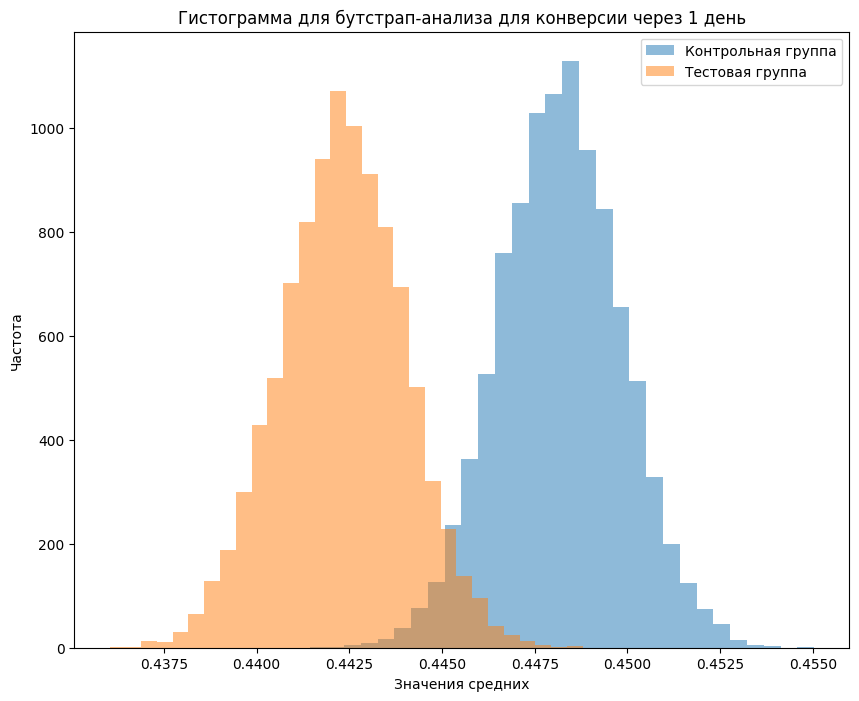

In [ ]:
# визуализация по средним значениям, сгенерированным в рамках бутстрап-анализа для конверсии через 1 день

plt.figure(figsize= (10, 8))
plt.hist(bootstrap_means_A_1, bins=30, alpha=0.5, label='Контрольная группа')
plt.hist(bootstrap_means_B_1, bins=30, alpha=0.5, label='Тестовая группа')
plt.xlabel('Значения средних')
plt.ylabel ('Частота')
plt.title('Гистограмма для бутстрап-анализа для конверсии через 1 день')
plt.legend()
plt.show()

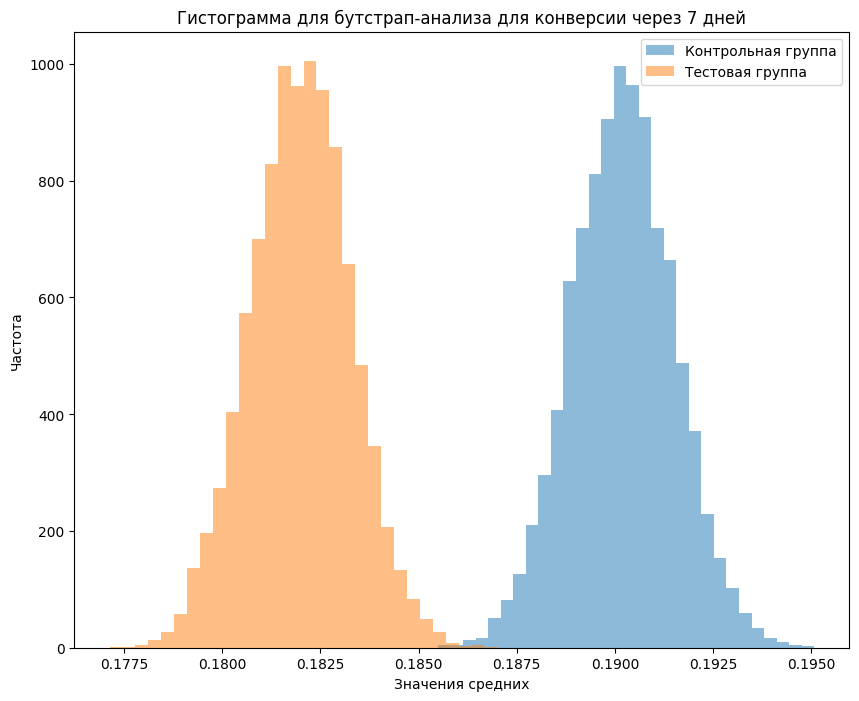

In [ ]:
# визуализация по средним значениям, сгенерированным в рамках бутстрап-анализа для конверсии через 7 дней

plt.figure(figsize= (10, 8))
plt.hist(bootstrap_means_A_7, bins=30, alpha=0.5, label='Контрольная группа')
plt.hist(bootstrap_means_B_7, bins=30, alpha=0.5, label='Тестовая группа')
plt.xlabel('Значения средних')
plt.ylabel ('Частота')
plt.title('Гистограмма для бутстрап-анализа для конверсии через 7 дней')
plt.legend()
plt.show()

In [ ]:
# визуально распределения нормальные
# дополнительно рассчитаем критерий Шапиро-Уилка, чтобы подтвердить нормальность распределения

shapiro(bootstrap_means_A_1)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9998489618301392, pvalue=0.7770920991897583)

In [ ]:
shapiro(bootstrap_means_B_1)

ShapiroResult(statistic=0.9997705221176147, pvalue=0.3607005774974823)

In [ ]:
shapiro(bootstrap_means_A_7)

ShapiroResult(statistic=0.9998881220817566, pvalue=0.9414330720901489)

In [ ]:
shapiro(bootstrap_means_B_7)

ShapiroResult(statistic=0.9997205138206482, pvalue=0.18819774687290192)

### Вывод по разделу
Поскольку p-значения не меньше 0,05 во всех случаях, мы не можем отвергнуть нулевую гипотезу. У нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

На основе визуализации делаем вывод, что по результатам бутстрап-анализа средние значения конверсии возврата через 1 день для контрольной группы выше (т.к. график расположен правее), что подтверждает наш вывод, сделанный в шаге 3.1.

Тот же вывод делаем и для конверсии после 7 дней, однако здесь различия ещё более выражены, что подтверждает наши предыдущие выводы о наличии статистически значимого различия между группами по этой метрике с ухудшением для тестовой группы.

### 3.4. Конверсии групп

(0.0, 1.0)

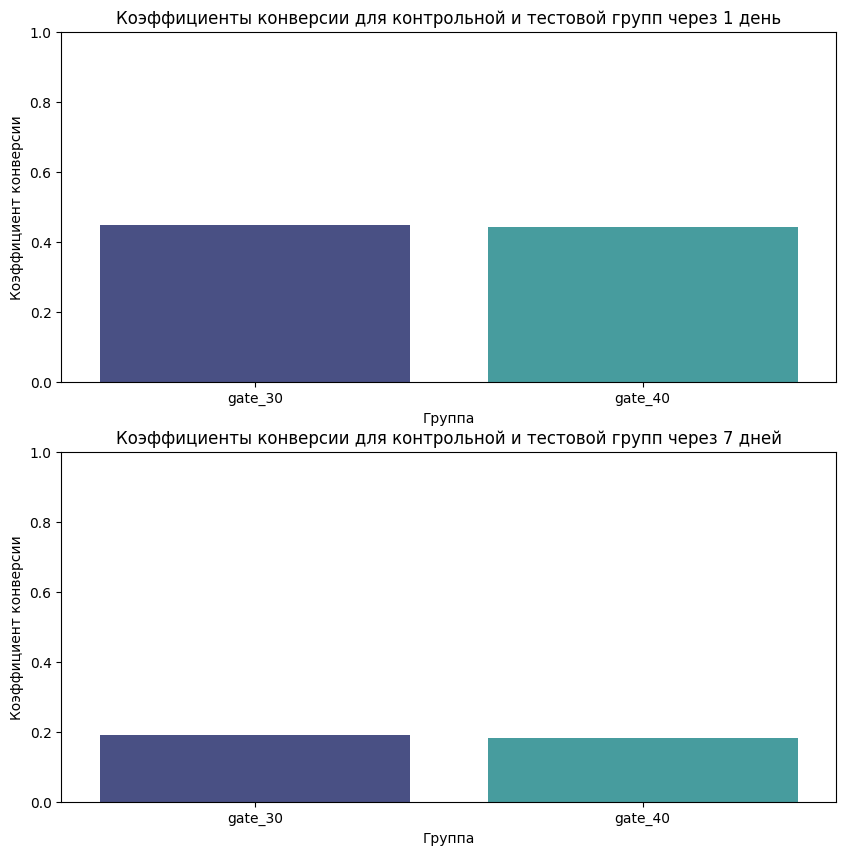

In [ ]:
# Строим графики
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Коэффициенты конверсии для контрольной и тестовой групп для установки через 1 день

conversion_rates_1 = df.groupby('version')['retention_1'].mean()
sns.barplot(x=conversion_rates_1.index, y=conversion_rates_1.values, palette="mako", ax=ax[0])
ax[0].set_title('Коэффициенты конверсии для контрольной и тестовой групп через 1 день')
ax[0].set_ylabel('Коэффициент конверсии')
ax[0].set_xlabel('Группа')
ax[0].set_ylim(0,1)

# Коэффициенты конверсии для контрольной и тестовой групп для установки через 7 дней

conversion_rates_7 = df.groupby('version')['retention_7'].mean()
sns.barplot(x=conversion_rates_7.index, y=conversion_rates_7.values, palette="mako", ax=ax[1])
ax[1].set_title('Коэффициенты конверсии для контрольной и тестовой групп через 7 дней')
ax[1].set_ylabel('Коэффициент конверсии')
ax[1].set_xlabel('Группа')
ax[1].set_ylim(0,1)

In [ ]:
# проверим теперь гипотезу о равестве дисперсий для конверсий с использованием mean в качестве меры среднего

statistic_mean_1, p_value_mean_1 = levene(df[df['version']=='gate_30']['retention_1'], df[df['version']=='gate_40']['retention_1'], center = 'mean')
statistic_mean_1, p_value_mean_1

(12.68497479673476, 0.0003687953131210312)

In [ ]:
statistic_mean_7, p_value_mean_7 = levene(df[df['version']=='gate_30']['retention_7'], df[df['version']=='gate_40']['retention_7'], center = 'mean')
statistic_mean_7, p_value_mean_7

(40.05802778344181, 2.4768262928585837e-10)

In [ ]:
# посмотрим на сами коэффициенты конверсии

conversion_rates_1 = df.groupby('version')['retention_1'].mean()
conversion_rates_1

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [ ]:
conversion_rates_7 = df.groupby('version')['retention_7'].mean()
conversion_rates_7

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

### Вывод по разделу

Мы построили графики конверсии групп через 1 и через 7 дней.
Визуально конверсии не сильно отличаются (также см. п.3.1).

P-value для дисперсии конверсий менее уровня значимости, а значит что различия между группами дисперсий статистически значимы.

Однако если посмотреть на сами значения конверсий мы видим, что для возврата через 1 день после установки конверсия действительно почти не изменилась, а вот что касается 7 дней - в среднем она ниже в экспериментальной группе.


### 3.5. Доверительные интервалы

In [39]:
# рассчитаем доверительный интервал для среднего значения сыгранных раундов по группам
# для группы А

mean_value_group_a_rounds = np.mean(group_a_gamerounds)
standard_error_group_a_rounds = np.std(group_a_gamerounds, ddof=1) / np.sqrt(len(group_a_gamerounds))
margin_error_group_a_rounds = standard_error_group_a_rounds * np.abs(t.ppf((1- alpha) / 2, len(group_a_gamerounds) - 1))

In [64]:
lower_bound_group_a_rounds = mean_value_group_a_rounds - margin_error_group_a_rounds
upper_bound_group_a_rounds = mean_value_group_a_rounds + margin_error_group_a_rounds

In [41]:
# для группы В

mean_value_group_b_rounds = np.mean(group_b_gamerounds)
standard_error_group_b_rounds = np.std(group_b_gamerounds, ddof=1) / np.sqrt(len(group_b_gamerounds))
margin_error_group_b_rounds = standard_error_group_b_rounds * np.abs(t.ppf((1- alpha) / 2, len(group_b_gamerounds) - 1))

In [60]:
lower_bound_group_b_rounds = mean_value_group_b_rounds - margin_error_group_b_rounds
upper_bound_group_b_rounds = mean_value_group_b_rounds + margin_error_group_b_rounds

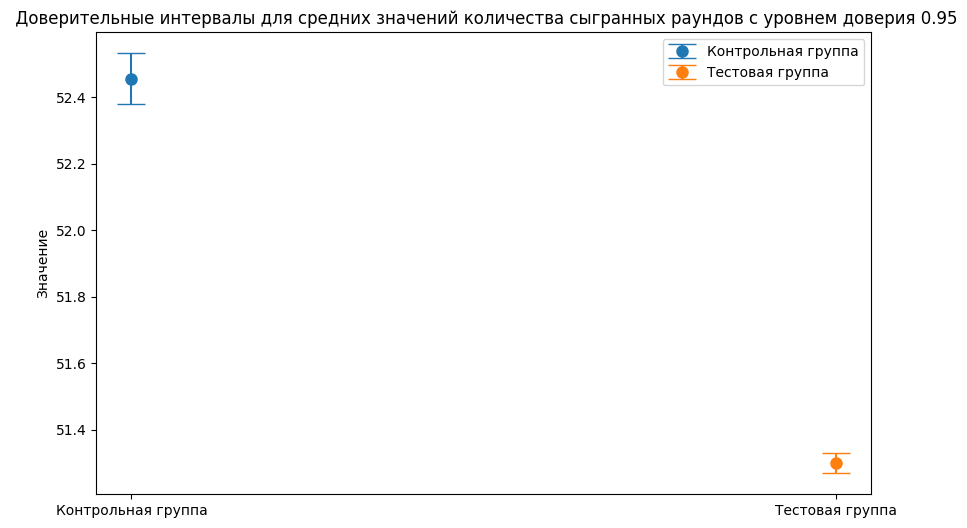

In [62]:
# визуализация

plt.figure(figsize=(10, 6))
plt.errorbar(1, mean_value_group_a_rounds, yerr=margin_error_group_a_rounds, fmt='o', markersize=8, capsize=10, label='Контрольная группа')
plt.errorbar(2, mean_value_group_b_rounds, yerr=margin_error_group_b_rounds, fmt='o', markersize=8, capsize=10, label='Тестовая группа')
plt.xticks([1,2], ['Контрольная группа', 'Тестовая группа'])
plt.ylabel('Значение')
plt.title(f' Доверительные интервалы для средних значений количества сыгранных раундов с уровнем доверия {1 - alpha}')
plt.legend()
plt.tight_layout
plt.show()

In [65]:
print(f'Контрольная группа: доверительные интервалы для средних значений количества сыгранных раундов[{lower_bound_group_a_rounds:.2f}, {upper_bound_group_a_rounds: .2f}], Среднее значение: {mean_value_group_a_rounds: .2f}')
print(f'Тестовая группа: доверительные интервалы для средних значений количества сыгранных раундов [{lower_bound_group_b_rounds:.2f}, {upper_bound_group_b_rounds: .2f}], Среднее значение: {mean_value_group_b_rounds: .2f}')

Контрольная группа: доверительные интервалы для средних значений количества сыгранных раундов[52.38,  52.53], Среднее значение:  52.46
Тестовая группа: доверительные интервалы для средних значений количества сыгранных раундов [51.27,  51.33], Среднее значение:  51.30


In [53]:
# рассчитаем доверительный интервал для среднего значения конверсии через 1 день после установки по группам
# для группы А

mean_value_group_a_1 = np.mean(group_a_1)
standard_error_group_a_1 = np.std(group_a_1, ddof=1) / np.sqrt(len(group_a_1))
margin_error_group_a_1 = standard_error_group_a_1 * np.abs(t.ppf((1- alpha) / 2, len(group_a_1) - 1))

In [83]:
lower_bound_group_a_1 = mean_value_group_a_1 - margin_error_group_a_1
upper_bound_group_a_1 = mean_value_group_a_1 + margin_error_group_a_1

In [75]:
# для группы В

mean_value_group_b_1 = np.mean(group_b_1)
standard_error_group_b_1 = np.std(group_b_1, ddof=1) / np.sqrt(len(group_b_1))
margin_error_group_b_1 = standard_error_group_b_1 * np.abs(t.ppf((1- alpha) / 2, len(group_b_1) - 1))

In [67]:
lower_bound_group_b_1 = mean_value_group_b_1 - margin_error_group_b_1
upper_bound_group_b_1 = mean_value_group_b_1 + margin_error_group_b_1

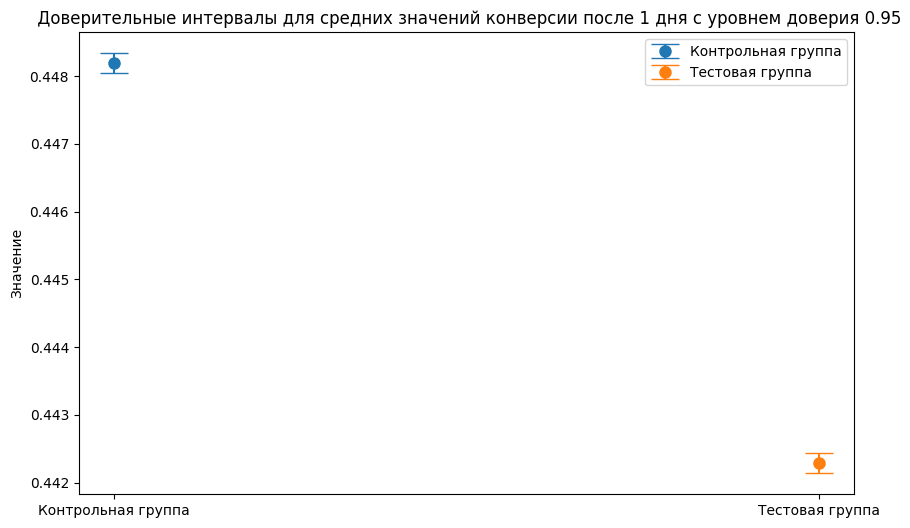

In [58]:
# визуализация

plt.figure(figsize=(10, 6))
plt.errorbar(1, mean_value_group_a_1, yerr=margin_error_group_a_1, fmt='o', markersize=8, capsize=10, label='Контрольная группа')
plt.errorbar(2, mean_value_group_b_1, yerr=margin_error_group_b_1, fmt='o', markersize=8, capsize=10, label='Тестовая группа')
plt.xticks([1,2], ['Контрольная группа', 'Тестовая группа'])
plt.ylabel('Значение')
plt.title(f' Доверительные интервалы для средних значений конверсии после 1 дня с уровнем доверия {1 - alpha}')
plt.legend()
plt.tight_layout
plt.show()

In [88]:
print(f'Контрольная группа: доверительные интервалы для средних значений [{lower_bound_group_a_1:.4f}, {upper_bound_group_a_1: .4f}], Среднее значение: {mean_value_group_a_1: .4f}')
print(f'Тестовая группа: доверительные интервалы для средних значений [{lower_bound_group_b_1:.4f}, {upper_bound_group_b_1: .4f}], Среднее значение: {mean_value_group_b_1: .4f}')

Контрольная группа: доверительные интервалы для средних значений [0.4480,  0.4483], Среднее значение:  0.4482
Тестовая группа: доверительные интервалы для средних значений [0.4421,  0.4424], Среднее значение:  0.4423


In [76]:
# рассчитаем доверительный интервал для среднего значения конверсии через 7 дней после установки по группам
# для группы А

mean_value_group_a_7 = np.mean(group_a_7)
standard_error_group_a_7 = np.std(group_a_7, ddof=1) / np.sqrt(len(group_a_7))
margin_error_group_a_7 = standard_error_group_a_7 * np.abs(t.ppf((1- alpha) / 2, len(group_a_7) - 1))

In [78]:
lower_bound_group_a_7 = mean_value_group_a_7 - margin_error_group_a_7
upper_bound_group_a_7 = mean_value_group_a_7 + margin_error_group_a_7

In [79]:
# для группы В

mean_value_group_b_7 = np.mean(group_b_7)
standard_error_group_b_7 = np.std(group_b_7, ddof=1) / np.sqrt(len(group_b_7))
margin_error_group_b_7 = standard_error_group_b_7 * np.abs(t.ppf((1- alpha) / 2, len(group_b_7) - 1))

In [80]:
lower_bound_group_b_7 = mean_value_group_b_7 - margin_error_group_b_7
upper_bound_group_b_7 = mean_value_group_b_7 + margin_error_group_b_7

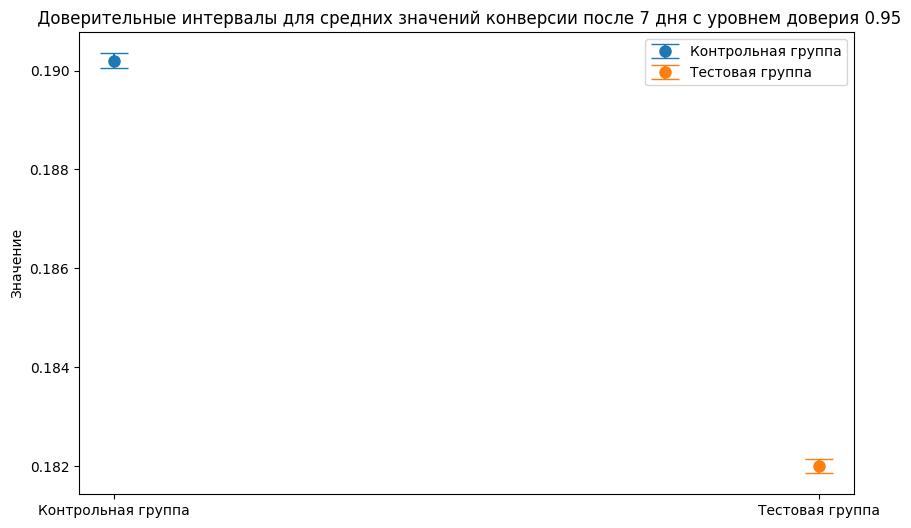

In [81]:
# визуализация

plt.figure(figsize=(10, 6))
plt.errorbar(1, mean_value_group_a_7, yerr=margin_error_group_a_1, fmt='o', markersize=8, capsize=10, label='Контрольная группа')
plt.errorbar(2, mean_value_group_b_7, yerr=margin_error_group_b_1, fmt='o', markersize=8, capsize=10, label='Тестовая группа')
plt.xticks([1,2], ['Контрольная группа', 'Тестовая группа'])
plt.ylabel('Значение')
plt.title(f' Доверительные интервалы для средних значений конверсии после 7 дня с уровнем доверия {1 - alpha}')
plt.legend()
plt.tight_layout
plt.show()

In [89]:
print(f'Контрольная группа: доверительные интервалы для средних значений [{lower_bound_group_a_7:.4f}, {upper_bound_group_a_7: .4f}], Среднее значение: {mean_value_group_a_7: .4f}')
print(f'Тестовая группа: доверительные интервалы для средних значений [{lower_bound_group_b_7:.4f}, {upper_bound_group_b_7: .4f}], Среднее значение: {mean_value_group_b_7: .4f}')

Контрольная группа: доверительные интервалы для средних значений [0.1901,  0.1903], Среднее значение:  0.1902
Тестовая группа: доверительные интервалы для средних значений [0.1819,  0.1821], Среднее значение:  0.1820


### Вывод по разделу
1. Количество сыгранных раундов

Вероятность того, что доверительный интервал [52.38,  52.53] содержит среднее значение количества сыгранных раундов для контрольной группы, составляет 95%.

Вероятность того, что доверительный интервал [51.27,  51.33] содержит среднее значение количества сыгранных раундов для тестовой группы, составляет 95%.

Интервалы не пересекаются.

2. Конверсия после 1 дня

Вероятность того, что доверительный интервал [0.4480,  0.4483] содержит среднее значение конверсии через 1 день после установки для контрольной группы, составляет 95%.

Вероятность того, что доверительный интервал [0.4421,  0.4424] содержит среднее значение конверсии через 1 день после установки для тестовой группы, составляет 95%.

Интервалы не пересекаются.

3. Конверсия после 7 дней

Вероятность того, что доверительный интервал [0.1901,  0.1903] содержит среднее значение конверсии через 7 дней после установки для контрольной группы, составляет 95%.

Вероятность того, что доверительный интервал [0.1819,  0.1821] содержит среднее значение конверсии через 7 дней после установки для тестовой группы, составляет 95%.

Интервалы не пересекаются.

### Общий вывод

### Первичный анализ и визуализация

По графикам pie мы видим, что в тестовой группе количество вернувшихся пользователей чуть меньше, чем в контрольной, при чём это касается возврата как через 1 день после установки, так и через 7 дней.

В отношении количества сыгранных раундов визуально распределение примерно одинаково, однако при дополнительном расчете мы видим, что среднее количество раундов в контрольной группе чуть больше.

**Таким образом, вариант, предложенный группе B, хуже, поэтому внедрять эти изменения дальше не стоит. Далее проверяем статистическую значимость данного предварительного вывод.**

### Параметрические критерии сравнения групп (количественные данные)
На основании теста сравнения групп мы делаем вывод, что **статистически значимые различия между группами не обнаружены с точки зрения количества сыгранных матчей.**
Однако p-value фактически очень близко к порогу значимости, что означает, что можно принять осторожный подход и оставить нулевую гипотезу о наличии статистически значимого различия, осознавая, что результаты не достигают статистической значимости при уровне значимости 0.05.
Возможно, стоит провести более крупное исследование для получения более точных результатов.

###  Параметрические критерии сравнения групп (качественные данные)
**Для конверсии через 1 день не можем считать результат статистически значимым**, так как p-value более 0.05.
**Для конверсии через 7 дней результат статистически значим**, так как p-value менее 0.05.

**Это означает, что результат внедрения изменений по метрике возврата через 7 дней хуже, чем до изменений, а по прочим изменениям различия статистически не значимы.**

### Бутсрап-анализ
Поскольку p-значения не меньше 0,05 во всех случаях, мы не можем отвергнуть нулевую гипотезу. У нас нет достаточных доказательств, чтобы сказать, что данные выборки не получены из нормального распределения.

На основе визуализации делаем вывод, что **по результатам бутстрап-анализа средние значения конверсии возврата через 1 день для контрольной группы выше **(т.к. график расположен правее), что подтверждает наш вывод, сделанный в шаге 3.1. Однако принимая во внимание **отсутствие статистической значимости различий между данными группами, мы не можем опираться на этот вывод.**

Тот же вывод делаем и **для конверсии после 7 дней, однако здесь различия ещё более выражены, что подтверждает наши предыдущие выводы о наличии статистически значимого различия между группами по этой метрике с ухудшением для тестовой группы.**

### Конверсии групп

Мы построили графики конверсии групп через 1 и через 7 дней.
Визуально конверсии не сильно отличаются (также см. п.3.1).

P-value для дисперсии конверсий менее уровня значимости, а значит что различия между группами дисперсий статистически значимы.

Однако если посмотреть на сами значения конверсий мы видим, что для возврата через 1 день после установки конверсия действительно почти не изменилась, а вот что касается 7 дней - в среднем она ниже в экспериментальной группе.

### Доверительные интервалы
1. Количество сыгранных раундов

Вероятность того, что доверительный интервал [52.38,  52.53] содержит среднее значение количества сыгранных раундов для контрольной группы, составляет 95%.

Вероятность того, что доверительный интервал [51.27,  51.33] содержит среднее значение количества сыгранных раундов для тестовой группы, составляет 95%.

Интервалы не пересекаются.

2. Конверсия после 1 дня

Вероятность того, что доверительный интервал [0.4480,  0.4483] содержит среднее значение конверсии через 1 день после установки для контрольной группы, составляет 95%.

Вероятность того, что доверительный интервал [0.4421,  0.4424] содержит среднее значение конверсии через 1 день после установки для тестовой группы, составляет 95%.

Интервалы не пересекаются.

3. Конверсия после 7 дней

Вероятность того, что доверительный интервал [0.1901,  0.1903] содержит среднее значение конверсии через 7 дней после установки для контрольной группы, составляет 95%.

Вероятность того, что доверительный интервал [0.1819,  0.1821] содержит среднее значение конверсии через 7 дней после установки для тестовой группы, составляет 95%.

Интервалы не пересекаются.

### Рекомендации для бизнеса

На основании проведённого анализа мы видим, что изменения, предложенные тестовой группе, немного ухудшили результаты, однако статистически значимое различие наблюдатся только в отношении конверсии по возвращению через 7 дней после установки.
Таким образом, мы не рекомендуем внедрять изменение на постоянной основе.